# Data Preparation
* In this file we will prepare the data that we will use to tasks included in this project.
* The dataset used is the [Wikipedia Movie Plots](https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots), that  contains descriptions of 34,886 movies from around the world, scraped from Wikipedia.
* This dataset can be found under the path <code>./data/wiki_movie_plots_deduped.csv</code>.

## Import packages
* To begin with, we will import the packages, that we will use in the following segments of this notebook:
    * [pandas](https://pandas.pydata.org/)
    * [scikit-learn](https://scikit-learn.org/stable/)
    * [NumPy](https://numpy.org/)
    * [matplotlib](https://matplotlib.org/)

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

## Read Dataset
* First, we will read our dataset and save it into a [pandas.Dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

In [2]:
df = pd.read_csv('data/wiki_movie_plots_deduped.csv')
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


* Let's check for *na* values first.

In [3]:
df.isna().sum()

Release Year           0
Title                  0
Origin/Ethnicity       0
Director               0
Cast                1422
Genre                  0
Wiki Page              0
Plot                   0
dtype: int64

* <code>Cast</code> is a column that we will **not** use later, so there are no *na* values that affect our preparation.

## Classification task
* The first task that we will perform (in the <code>./genre_classification.ipynb</code> notebook), is a genre **classification of the movies given their plot**.
* Here we will prepare the data for the classification.
* For this task we will need only the <code>Plot</code> (our X) and <code>Genre</code> (our Y) of the dataset.

In [4]:
df_clf = df[['Genre', 'Plot']]
df_clf.head()

,Genre,Plot
0,unknown,"A bartender is working at a saloon, serving dr..."
1,unknown,"The moon, painted with a smiling face hangs ov..."
2,unknown,"The film, just over a minute long, is composed..."
3,unknown,Lasting just 61 seconds and consisting of two ...
4,unknown,The earliest known adaptation of the classic f...


* Let's see how many different *genres* are included in the dataset, relative to the size of the dataset.

In [5]:
genres_count = len(df_clf['Genre'].unique())
dataset_size = len(df_clf)
print(f'{genres_count} different genres are included in the dataset. \n' +
        f'{dataset_size} different movies are included in the dataset.')

2265 different genres are included in the dataset. 
34886 different movies are included in the dataset.


* It seems that there are many different genres, so let's start by having a look at the **top 10 most frequently appeared genres**.

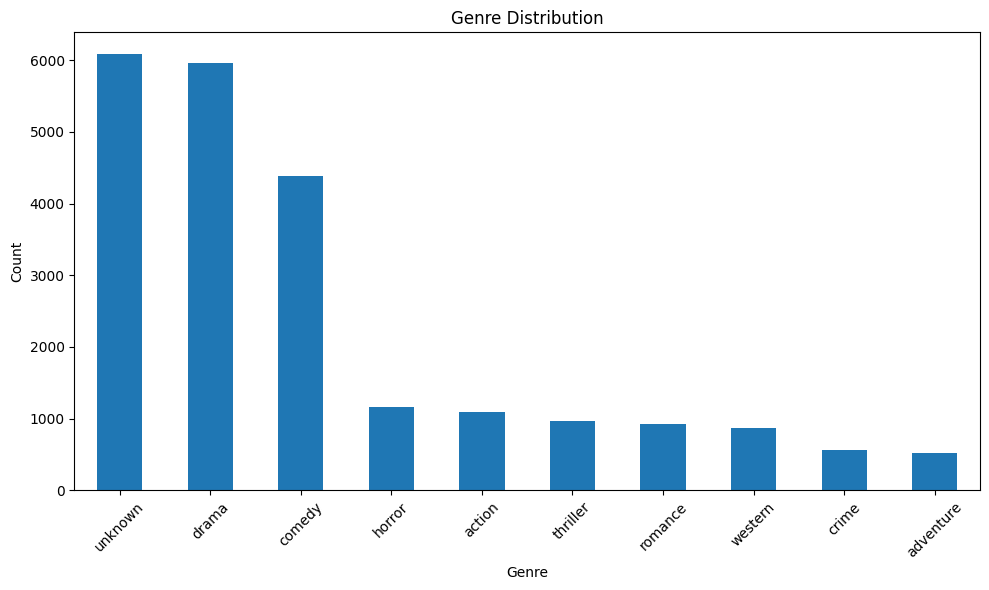

In [6]:
genre_value_counts_top_10 = df_clf['Genre'].value_counts()[:10]

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
genre_value_counts_top_10.plot(kind='bar')
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the chart
plt.show()

* First, we can notice that <code>unknown</code> category is the one appearing the most frequently. But it is not useful for our model, so we will **not use** it.
* Then, we can notice that there is a big gap between *drama* and *comedy* with the rest of the genres.
* So, as NLP generally demands a large dataset for Model Training, for the particular task we will focus on the **two** most frequent genres, *drama* and *comedy*.
* The task at hand then is a *binary classification task*.
* Following, we will keep the rows of the dataset that refer only to these genres.

In [7]:
frequent_genres = ['drama', 'comedy']
df_clf = df_clf[df_clf['Genre'].isin(frequent_genres)]
df_clf.reset_index(inplace=True, drop=True)
len(df_clf)

10343

* Many lines were dropped, but that's ok.
* Lastly, in order to use *strings* (the genres) as labels, we will encode them into numerical values, as it is required.
* To do that we will use the <code>LabelEncoder</code> provided by [scikit-learn](https://scikit-learn.org/stable/).

In [8]:
label_encoder = LabelEncoder()
df_clf.loc[:, 'Genre_Encoded'] = label_encoder.fit_transform(df_clf['Genre'])
df_clf.head()

,Genre,Plot,Genre_Encoded
0,comedy,The film is about a family who move to the sub...,0
1,comedy,Before heading out to a baseball game at a nea...,0
2,comedy,The plot is that of a black woman going to the...,0
3,drama,On a beautiful summer day a father and mother ...,1
4,drama,A thug accosts a girl as she leaves her workpl...,1


* Let's also keep the mapping of the encoding.

In [9]:
encoding_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_, ))
encoding_mapping

{0: 'comedy', 1: 'drama'}

* Following, we will extract all the data that we need for our modeling under the path <code>./data/classification</code>.
* Specifically:
    * The **plots**: will be used as the independent variables of the classification (X) and will be saved in <code>./data/classification/plots.npy</code>
    * The **genres (encoded)** of each plot: will be used as labels (Y) and will be saved in <code>./data/classification/genres_encoded.npy</code>
    * The **encoding** of the genres, that will be saved in <code>./data/classification/genre_encoding.pickle</code>

In [10]:
# Create the directory if it doesn't exist
save_dir = './data/classification/'
os.makedirs(save_dir, exist_ok=True)

np.save('./data/classification/plots.npy', df_clf['Plot'].to_numpy())
np.save('./data/classification/genres_encoded.npy', df_clf['Genre_Encoded'].to_numpy())
with open('./data/classification/genre_encoding.pickle', "wb") as file:
    pickle.dump(encoding_mapping, file)